In [1]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG16
from tensorboard import notebook
from tensorflow import keras 
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

2023-12-07 16:13:31.062582: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


100%|██████████| 186/186 [00:00<00:00, 193.55it/s]


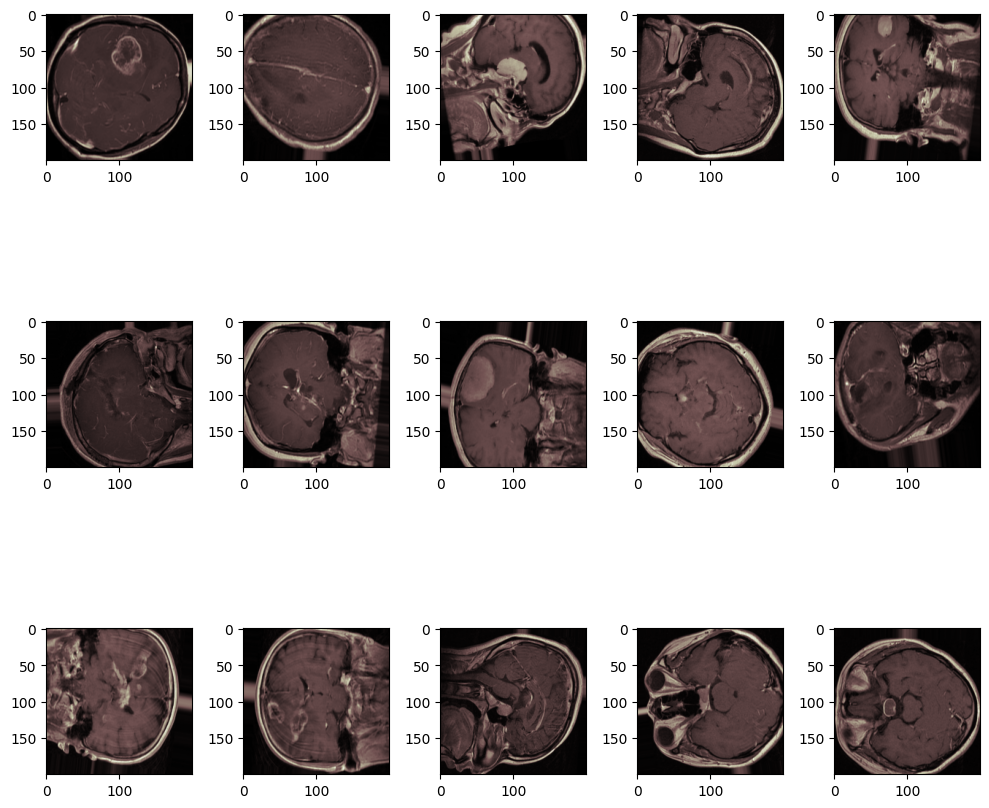

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)


In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [2]:
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    ReLU,
    MaxPooling2D,
    Concatenate,
    GlobalMaxPooling2D,
    Dropout,
    Dense,
    Lambda,
    Reshape,
    Activation,
    Multiply,
    Add
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def block(inputs, filters):
    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Conv2D(filters, 3, padding='same')(a)
    b = BatchNormalization()(b)
    b = ReLU()(b)
    
    c = Conv2D(filters, 3, padding='same')(b)
    c = BatchNormalization()(c)
    c = ReLU()(c)
    
    d = Conv2D(filters, 3, padding='same')(c)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    mid = Concatenate()([a, b, c, d])
    mid = Conv2D(2 * filters, 1, padding='same')(mid)
    mid = BatchNormalization()(mid)
    mid = ReLU()(mid)
    
    x = Conv2D(filters * 2, 1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Add()([mid, x])
    
    y = Conv2D(filters * 2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y

def Global_attention_block(C_A):
    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(C_A)
    y = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(C_A)
    
    x = Concatenate()([x, y])
    x = Activation('relu')(x)
    x = Conv2D(1, 1, padding='same')(x)
    x = Activation('sigmoid')(x)
    S_A = Multiply()([x, C_A])
    
    return S_A

def self_attention(inp):
    shp = inp.shape
    a = Conv2D(shp[3] // 8, 1, padding='same')(inp)
    a = Activation('relu')(a)
    
    b = Conv2D(shp[3] // 8, 1, padding='same')(inp)
    b = Activation('relu')(b)
    
    c = Conv2D(shp[3] // 8, 1, padding='same')(inp)
    c = Activation('relu')(c)
    
    a = Reshape((shp[1] * shp[2], shp[3] // 8))(a)
    b = Reshape((shp[1] * shp[2], shp[3] // 8))(b)
    b = K.permute_dimensions(b, (0, 2, 1))
    c = Reshape((shp[1] * shp[2], shp[3] // 8))(c)
    inter = K.batch_dot(a, b)
    inter = Activation('softmax')(inter)
    out = K.batch_dot(inter, c)
    out = Reshape((shp[1], shp[2], shp[3] // 8))(out)
    out = Conv2D(shp[3], 1, padding='same')(out)
    out = Activation('relu')(out)
    
    return out

def channel_attention(inputs):
    shape = K.int_shape(inputs)
    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // 8, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    x = Multiply()([x, inputs])
    
    return x

def load_model():
    K.clear_session()
    inputs = Input(shape=(200, 200, 3))
    x = Conv2D(16, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(16, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D()(x)
    
    a1 = block(x, 32)
    x = MaxPooling2D()(a1)
    
    a2 = block(x, 64)
    x = MaxPooling2D()(a2)
    
    a3 = block(x, 128)
    a31 = self_attention(a3)
    a32 = Global_attention_block(a3)
    a3 = Add()([a31, a32])
    x = channel_attention(a3)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model


In [4]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2023-12-07 15:11:06.590835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 15:11:06.902142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:42:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 200, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-ARM-Net.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])

Epoch 1/50


2023-12-07 15:11:19.484861: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-07 15:11:20.054585: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-07 15:11:20.054607: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-12-07 15:11:20.054757: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-07 15:11:20.588482: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.7693 - accuracy: 0.6568
Epoch 1: saving model to model-ARM-Net.h5
Epoch 1: 11.77 seconds
264/264 [==============================] - 12s 27ms/step - loss: 0.7693 - accuracy: 0.6568 - val_loss: 3.8842 - val_accuracy: 0.3558 - lr: 1.0000e-04
Epoch 2/50
262/264 [============================>.] - ETA: 0s - loss: 0.4026 - accuracy: 0.8457
Epoch 2: saving model to model-ARM-Net.h5
Epoch 2: 5.78 seconds
264/264 [==============================] - 6s 22ms/step - loss: 0.4027 - accuracy: 0.8460 - val_loss: 2.4675 - val_accuracy: 0.5009 - lr: 1.0000e-04
Epoch 3/50
262/264 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.8918
Epoch 3: saving model to model-ARM-Net.h5
Epoch 3: 5.71 seconds
264/264 [==============================] - 6s 22ms/step - loss: 0.2887 - accuracy: 0.8913 - val_loss: 0.2697 - val_accuracy: 0.8956 - lr: 1.0000e-04
Epoch 4/50
262/264 [============================>.] - ETA: 0s - loss: 0.2034 - acc

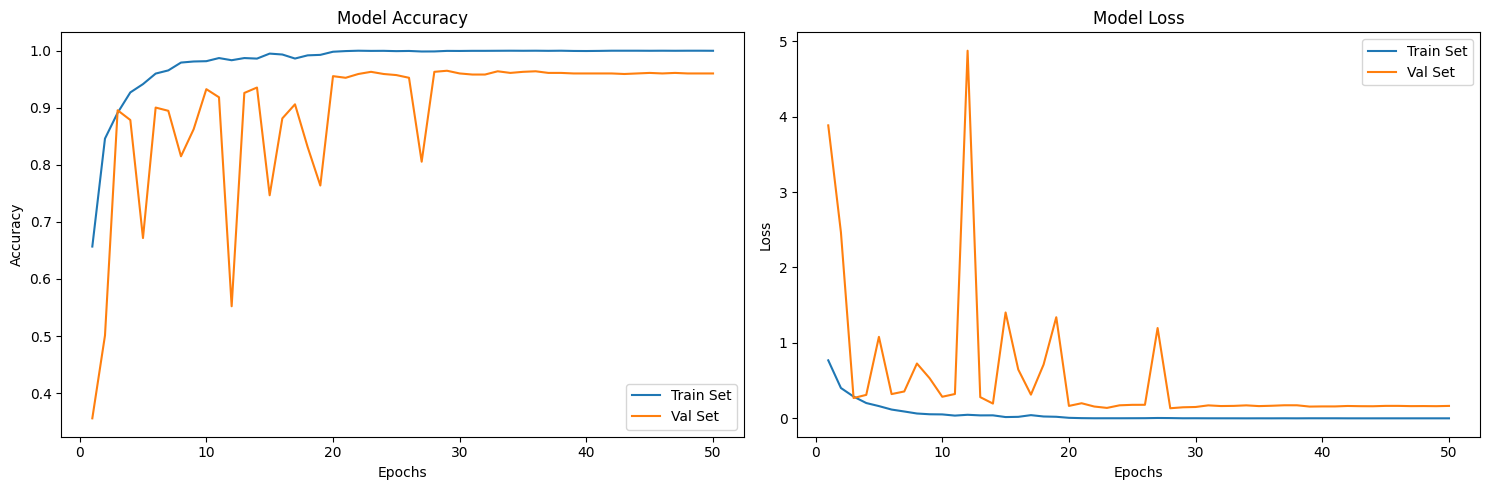

In [7]:
draw_curve(history)

20/20 [==============================] - 0s 8ms/step - loss: 0.1933 - accuracy: 0.9609
Test Accuracy:  96.09
              precision    recall  f1-score   support

      glioma     0.9719    0.9685    0.9702       286
  meningioma     0.9357    0.9225    0.9291       142
   pituitary     0.9630    0.9785    0.9707       186

    accuracy                         0.9609       614
   macro avg     0.9569    0.9565    0.9567       614
weighted avg     0.9608    0.9609    0.9608       614



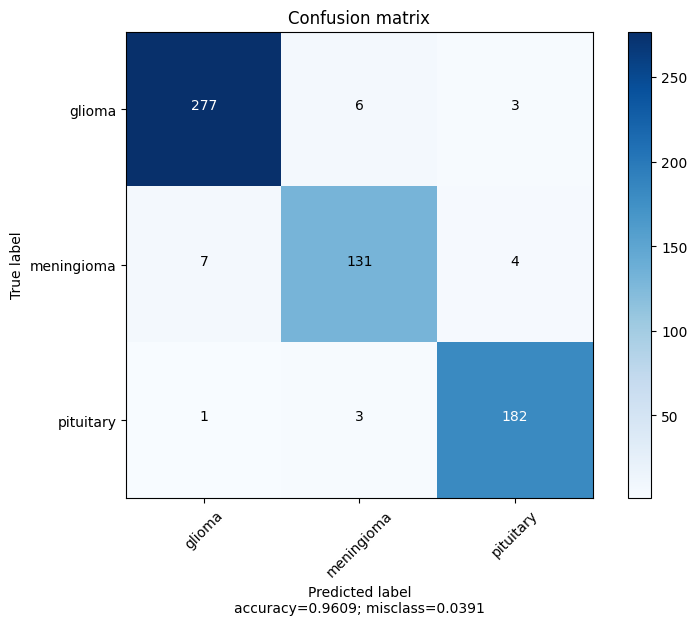

In [8]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

In [4]:
%reset -f

100%|██████████| 186/186 [00:00<00:00, 193.77it/s]


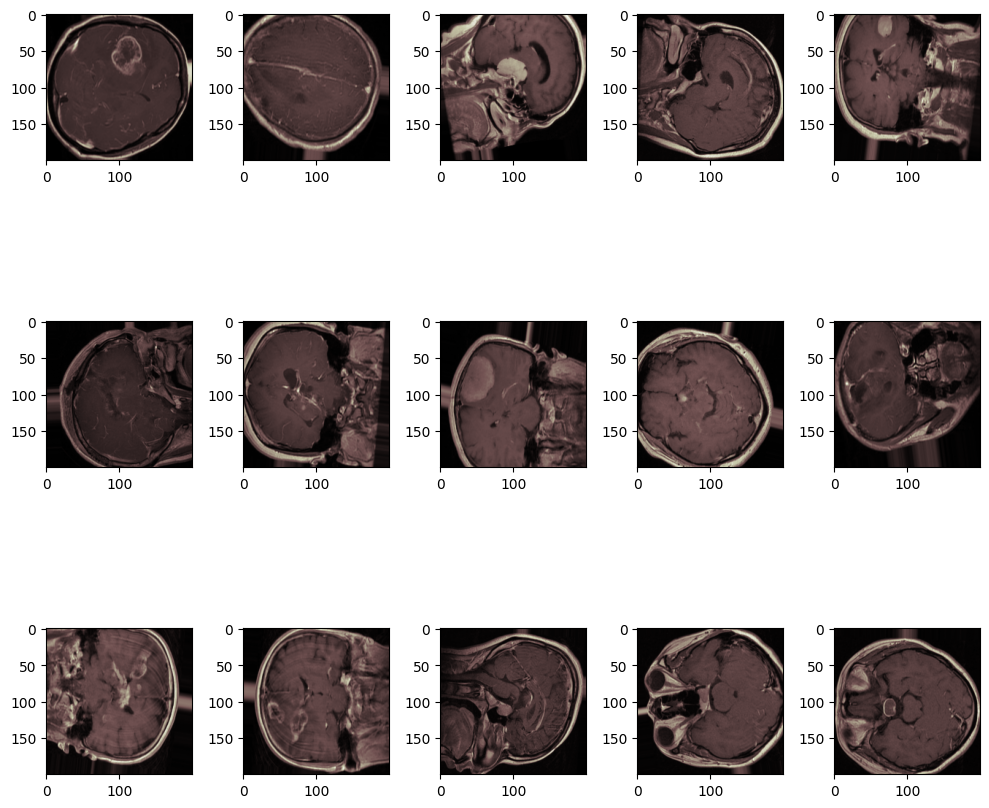

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
262/264 [============================>.] - ETA: 0s - loss: 0.9028 - accuracy: 0.5814
Epoch 1: saving model to model-ARM-Net.h5
Epoch 1: 9.22 seconds
264/264 [==============================] - 9s 25ms/step - loss: 0.9022 - accuracy: 0.5818 - val_loss: 1.1476 - val_accuracy: 0.4516 - lr: 1.0000e-04
Epoch 2/50
262/264 [============================>.] - ETA: 0s - loss: 0.5114 - accuracy: 0.8025
Epoch 2: saving model to model-ARM-Net.h5
Epoch 2: 5.69 seconds
264/264 [==============================] - 6s 22ms/step - loss: 0.5111 - accuracy: 0.8026 - val_loss: 1.3919 - val_accuracy: 0.4953 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.3278 - accuracy: 0.8802
Epoch 3: saving model to model-ARM-Net.h5
Epoch 3: 5.70 seconds
264/264 [==============================] - 6s 22ms/step - loss: 0.3278 - accuracy: 0.8802 - val_loss: 0.4844 - val_accuracy: 0.8055 - lr: 1.0000e-04
Epoch 4/50
26

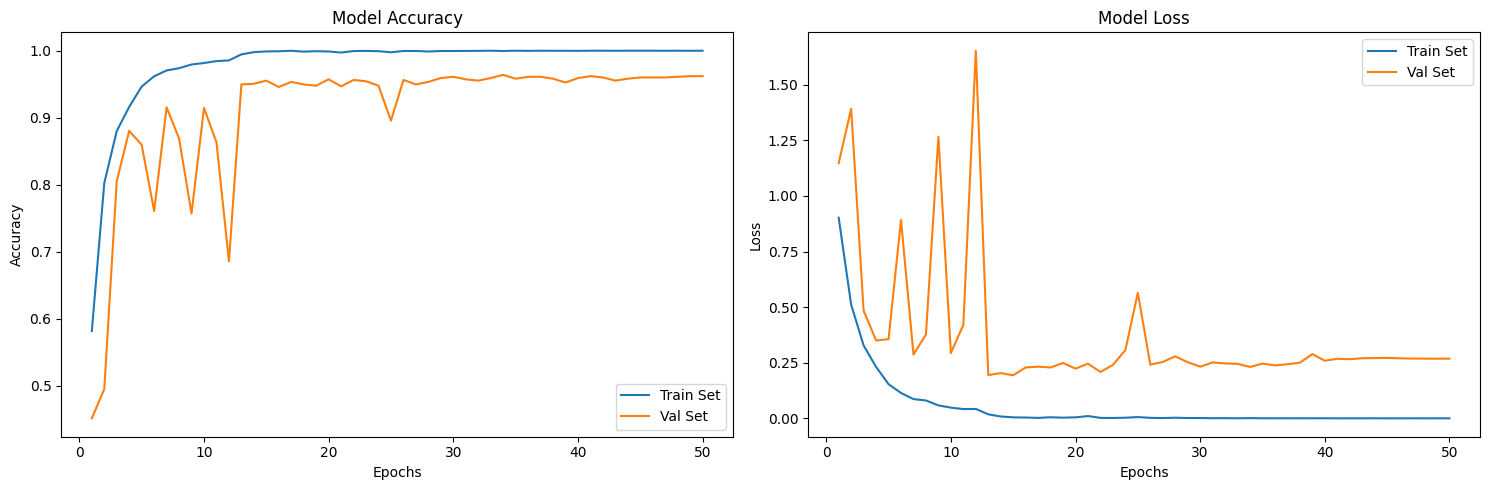

20/20 [==============================] - 0s 7ms/step - loss: 0.2937 - accuracy: 0.9446
Test Accuracy:  94.46
              precision    recall  f1-score   support

      glioma     0.9486    0.9685    0.9585       286
  meningioma     0.9044    0.8662    0.8849       142
   pituitary     0.9677    0.9677    0.9677       186

    accuracy                         0.9446       614
   macro avg     0.9403    0.9342    0.9370       614
weighted avg     0.9442    0.9446    0.9443       614



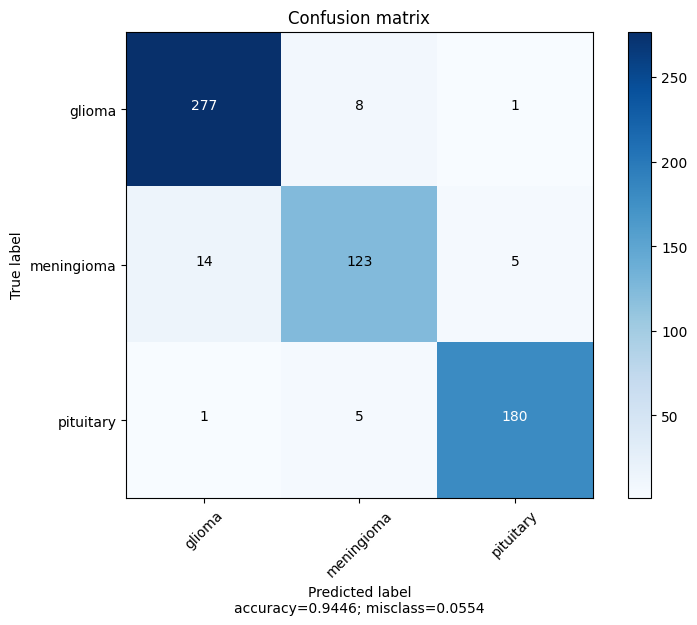

In [14]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-ARM-Net.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f

100%|██████████| 186/186 [00:00<00:00, 196.06it/s]


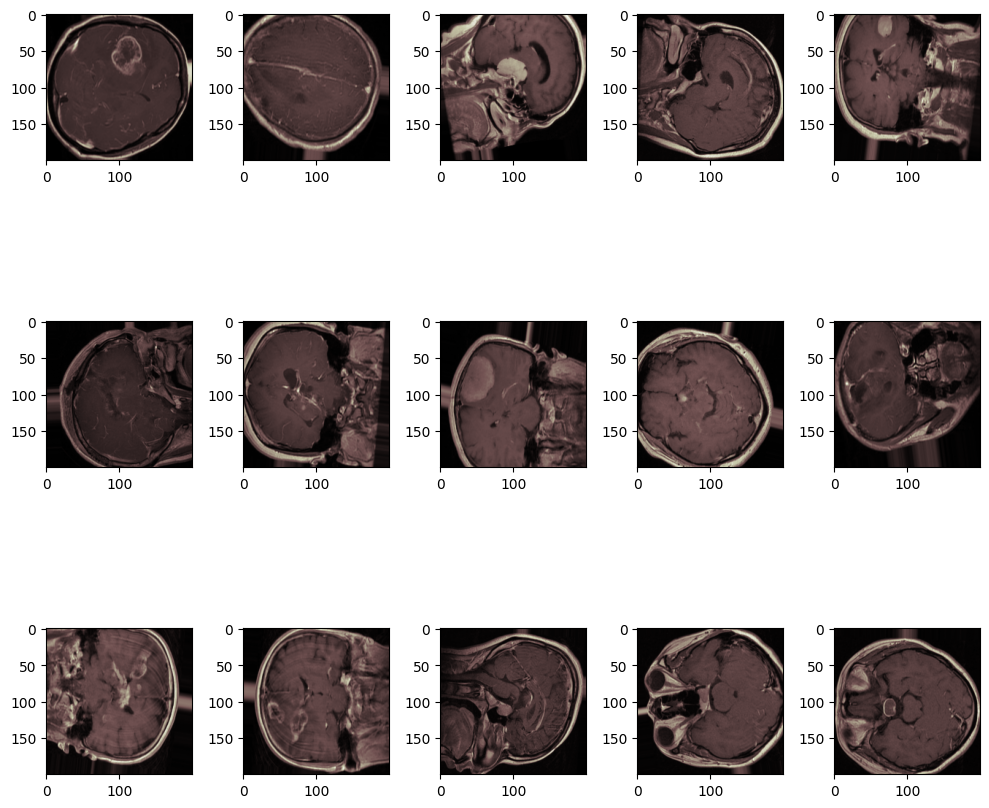

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
262/264 [============================>.] - ETA: 0s - loss: 0.7994 - accuracy: 0.6338
Epoch 1: saving model to model-ARM-Net.h5
Epoch 1: 8.37 seconds
264/264 [==============================] - 8s 25ms/step - loss: 0.7981 - accuracy: 0.6345 - val_loss: 1.8703 - val_accuracy: 0.3387 - lr: 1.0000e-04
Epoch 2/50
261/264 [============================>.] - ETA: 0s - loss: 0.4410 - accuracy: 0.8277
Epoch 2: saving model to model-ARM-Net.h5
Epoch 2: 5.56 seconds
264/264 [==============================] - 6s 21ms/step - loss: 0.4406 - accuracy: 0.8274 - val_loss: 2.2593 - val_accuracy: 0.4184 - lr: 1.0000e-04
Epoch 3/50
262/264 [============================>.] - ETA: 0s - loss: 0.3148 - accuracy: 0.8819
Epoch 3: saving model to model-ARM-Net.h5
Epoch 3: 5.49 seconds
264/264 [==============================] - 5s 21ms/step - loss: 0.3149 - accuracy: 0.8818 - val_loss: 0.3227 - val_accuracy: 0.8814 - lr: 1.0000e-04
Epoch 4/50
26

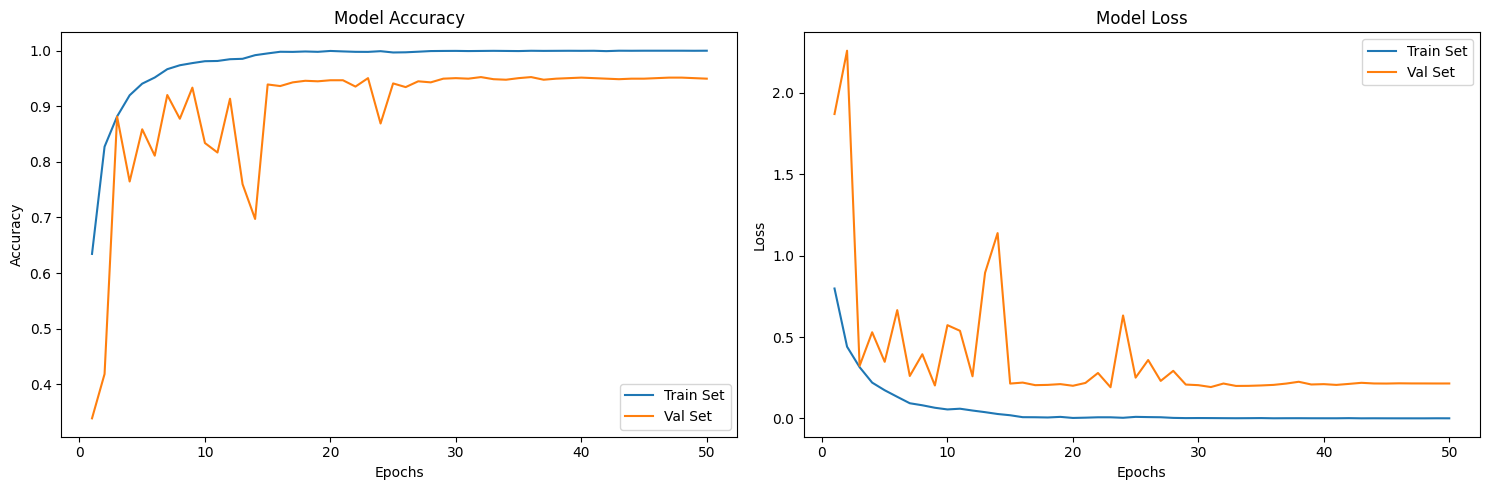

20/20 [==============================] - 0s 8ms/step - loss: 0.2556 - accuracy: 0.9446
Test Accuracy:  94.46
              precision    recall  f1-score   support

      glioma     0.9613    0.9545    0.9579       286
  meningioma     0.8951    0.9014    0.8982       142
   pituitary     0.9572    0.9624    0.9598       186

    accuracy                         0.9446       614
   macro avg     0.9379    0.9394    0.9386       614
weighted avg     0.9447    0.9446    0.9447       614



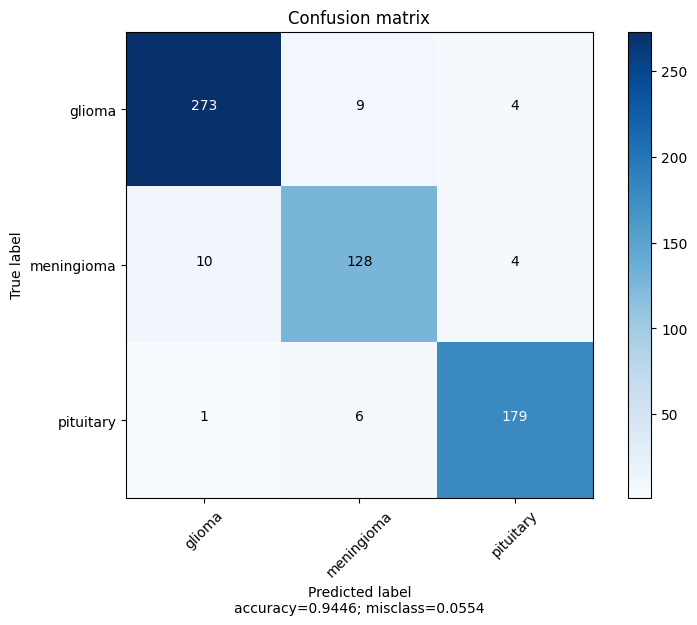

In [17]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-ARM-Net.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f

100%|██████████| 186/186 [00:00<00:00, 191.36it/s]


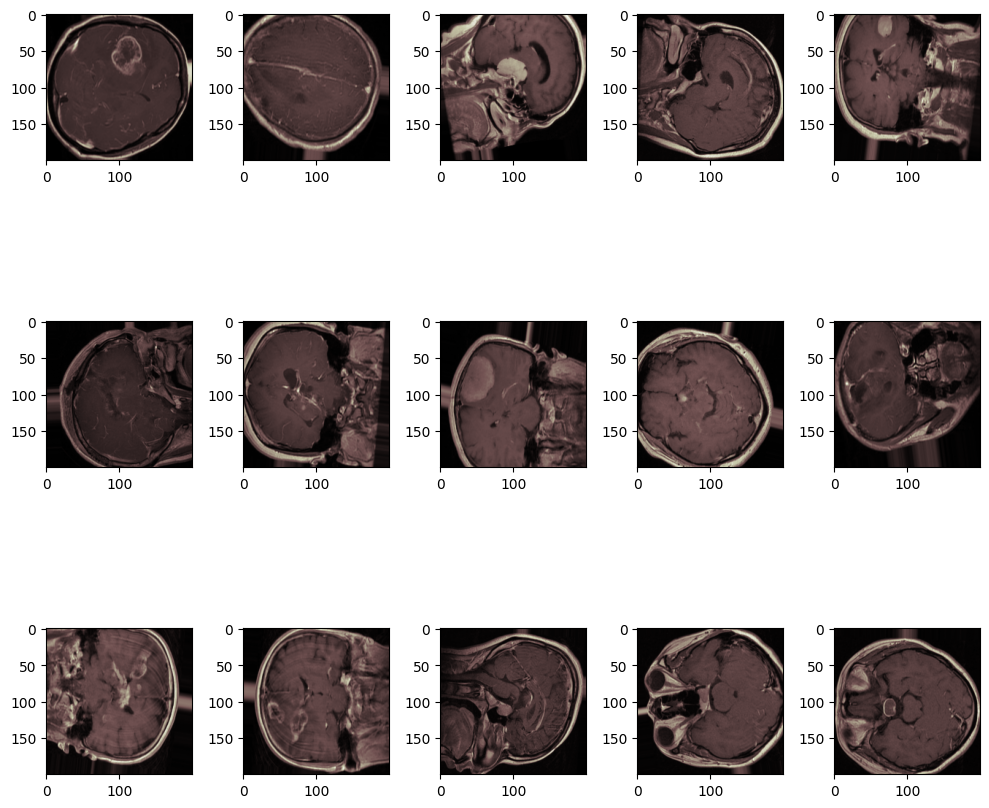

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
262/264 [============================>.] - ETA: 0s - loss: 0.8133 - accuracy: 0.6346
Epoch 1: saving model to model-ARM-Net.h5
Epoch 1: 8.37 seconds
264/264 [==============================] - 8s 25ms/step - loss: 0.8130 - accuracy: 0.6351 - val_loss: 2.2991 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
262/264 [============================>.] - ETA: 0s - loss: 0.4217 - accuracy: 0.8398
Epoch 2: saving model to model-ARM-Net.h5
Epoch 2: 5.64 seconds
264/264 [==============================] - 6s 21ms/step - loss: 0.4209 - accuracy: 0.8402 - val_loss: 1.6619 - val_accuracy: 0.5256 - lr: 1.0000e-04
Epoch 3/50
262/264 [============================>.] - ETA: 0s - loss: 0.2696 - accuracy: 0.9006
Epoch 3: saving model to model-ARM-Net.h5
Epoch 3: 5.51 seconds
264/264 [==============================] - 6s 21ms/step - loss: 0.2692 - accuracy: 0.9008 - val_loss: 1.1364 - val_accuracy: 0.6670 - lr: 1.0000e-04
Epoch 4/50
26

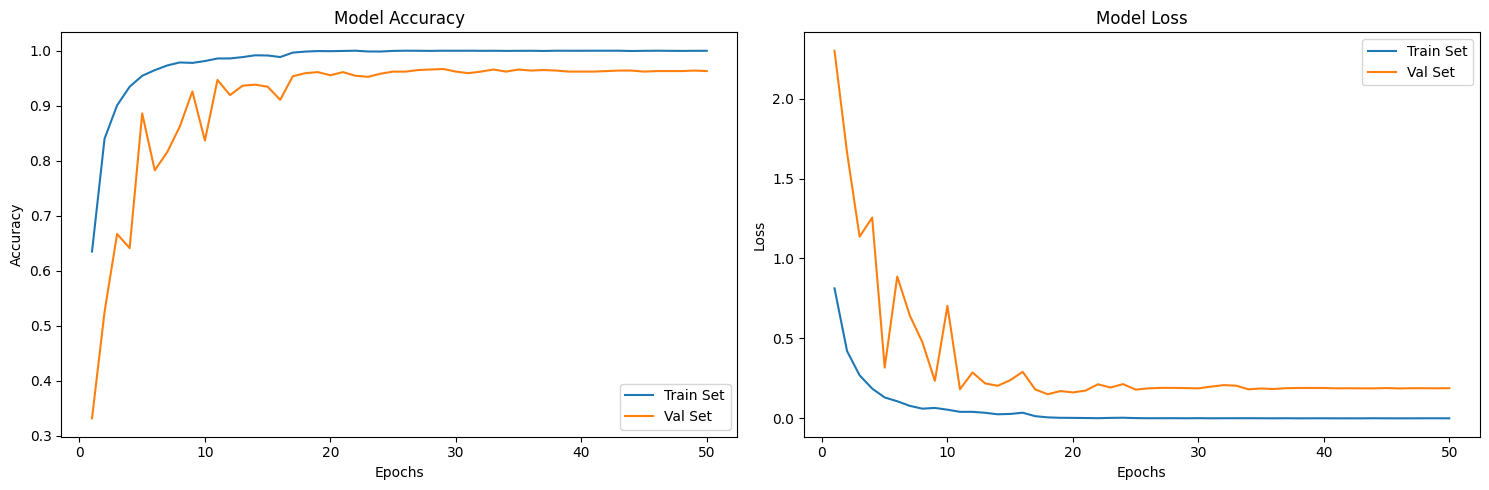

20/20 [==============================] - 0s 7ms/step - loss: 0.2005 - accuracy: 0.9479
Test Accuracy:  94.79
              precision    recall  f1-score   support

      glioma     0.9645    0.9510    0.9577       286
  meningioma     0.9412    0.9014    0.9209       142
   pituitary     0.9286    0.9785    0.9529       186

    accuracy                         0.9479       614
   macro avg     0.9448    0.9437    0.9438       614
weighted avg     0.9482    0.9479    0.9477       614



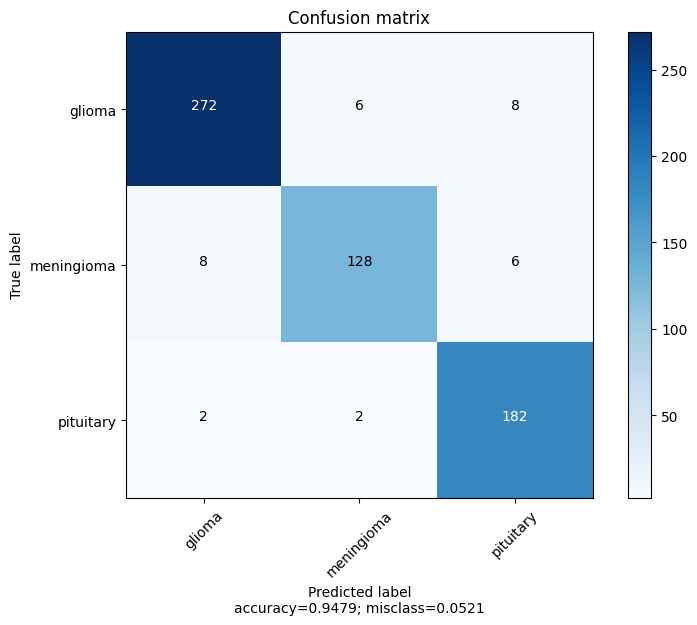

In [20]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-ARM-Net.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f

100%|██████████| 186/186 [00:00<00:00, 195.13it/s]


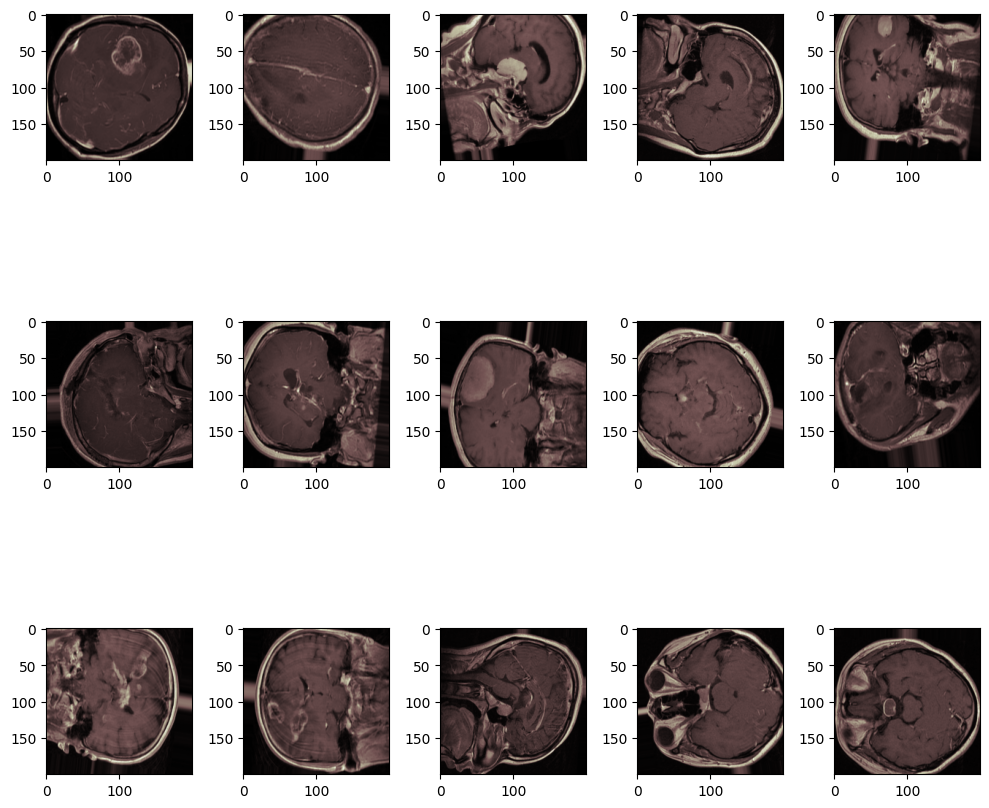

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)


2023-12-07 16:14:32.801561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 16:14:33.102912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:42:00.0, compute capability: 8.9


Epoch 1/50


2023-12-07 16:14:41.576191: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-07 16:14:42.161656: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-07 16:14:42.161691: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-12-07 16:14:42.161848: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-07 16:14:42.665619: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.8031 - accuracy: 0.6324
Epoch 1: saving model to model-ARM-Net.h5
Epoch 1: 11.49 seconds
264/264 [==============================] - 11s 26ms/step - loss: 0.8031 - accuracy: 0.6324 - val_loss: 2.9531 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
262/264 [============================>.] - ETA: 0s - loss: 0.4153 - accuracy: 0.8388
Epoch 2: saving model to model-ARM-Net.h5
Epoch 2: 5.75 seconds
264/264 [==============================] - 6s 22ms/step - loss: 0.4150 - accuracy: 0.8387 - val_loss: 2.9857 - val_accuracy: 0.5380 - lr: 1.0000e-04
Epoch 3/50
262/264 [============================>.] - ETA: 0s - loss: 0.2856 - accuracy: 0.8925
Epoch 3: saving model to model-ARM-Net.h5
Epoch 3: 5.66 seconds
264/264 [==============================] - 6s 21ms/step - loss: 0.2859 - accuracy: 0.8922 - val_loss: 0.4422 - val_accuracy: 0.8577 - lr: 1.0000e-04
Epoch 4/50
262/264 [============================>.] - ETA: 0s - loss: 0.1992 - acc

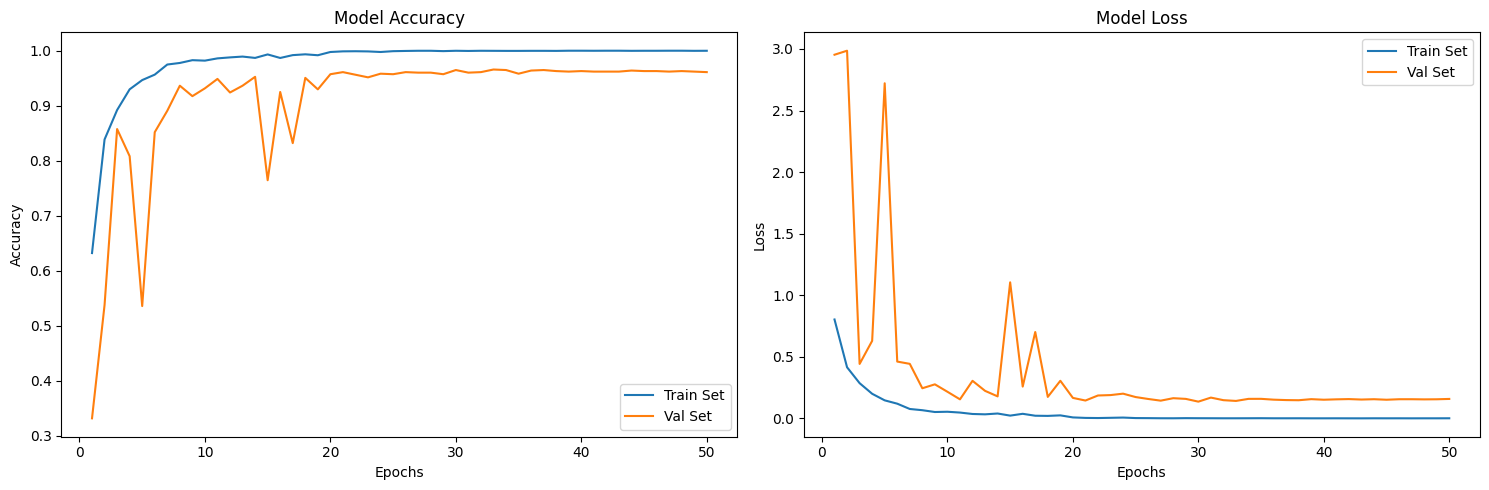

20/20 [==============================] - 0s 8ms/step - loss: 0.2165 - accuracy: 0.9511
Test Accuracy:  95.11
              precision    recall  f1-score   support

      glioma     0.9649    0.9615    0.9632       286
  meningioma     0.9143    0.9014    0.9078       142
   pituitary     0.9577    0.9731    0.9653       186

    accuracy                         0.9511       614
   macro avg     0.9456    0.9454    0.9455       614
weighted avg     0.9510    0.9511    0.9510       614



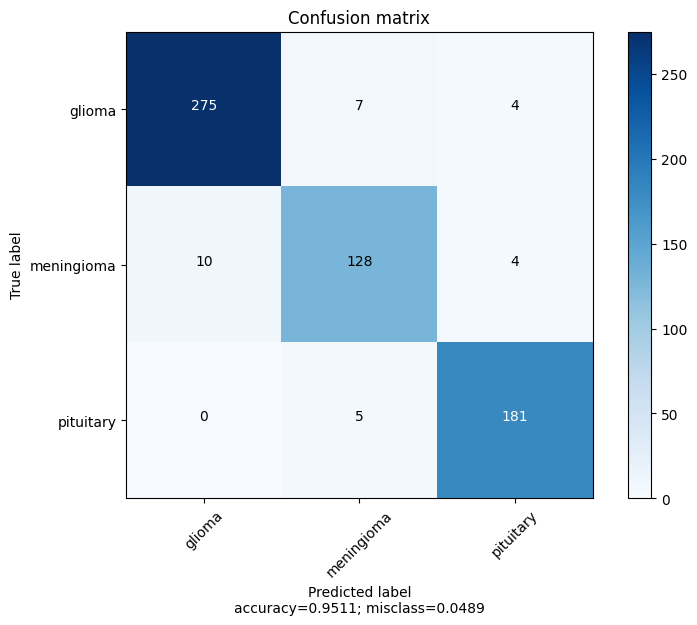

In [3]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-ARM-Net.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f